# Télécharger dataset

In [1]:
# Installer les dépendances nécessaires
!pip install torch torchvision transformers
!pip install tensorboard
!pip install nltk

# Import des bibliothèques
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter

import pandas as pd
import numpy as np
import os
from PIL import Image
import nltk

2025-12-25 18:38:18.095785: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766687898.320567      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766687898.383603      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766687898.915678      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766687898.915717      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766687898.915720      55 computation_placer.cc:177] computation placer alr

In [2]:
# Télécharger NLTK data pour tokenizer
nltk.download('punkt')

# Lire le fichier CSV des résultats
df = pd.read_csv('/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv', delimiter='|')
df.columns = df.columns.str.strip()  # Nettoyer les noms de colonnes
df['comment'] = df['comment'].str.strip()  # Nettoyer les commentaires

print("Colonnes du dataset :", df.columns)
print(df.head())
print(f"Nombre total d'images : {df['image_name'].nunique()}")
print(f"Nombre total de légendes : {len(df)}")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Colonnes du dataset : Index(['image_name', 'comment_number', 'comment'], dtype='object')
       image_name comment_number  \
0  1000092795.jpg              0   
1  1000092795.jpg              1   
2  1000092795.jpg              2   
3  1000092795.jpg              3   
4  1000092795.jpg              4   

                                             comment  
0  Two young guys with shaggy hair look at their ...  
1  Two young , White males are outside near many ...  
2   Two men in green shirts are standing in a yard .  
3       A man in a blue shirt standing in a garden .  
4            Two friends enjoy time spent together .  
Nombre total d'images : 31783
Nombre total de légendes : 158915


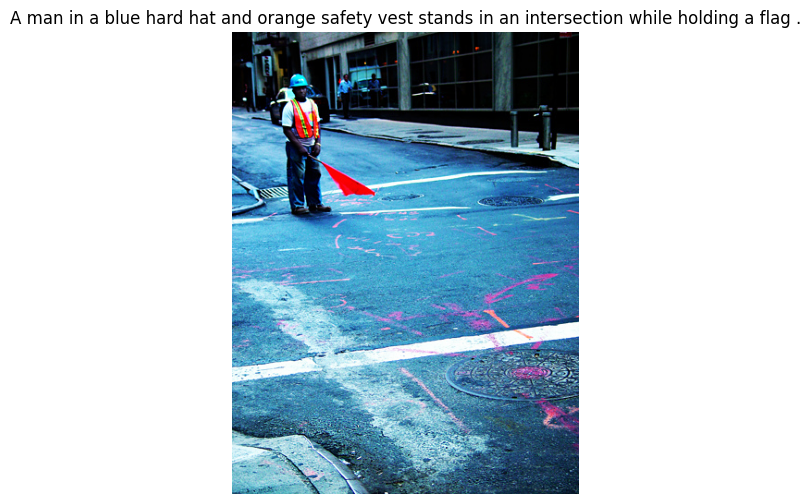

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Choisir une image au hasard ou par index
index = 120  # tu peux changer cet index pour afficher une autre image
image_name = df.loc[index, 'image_name']
caption = df.loc[index, 'comment']

# Construire le chemin complet vers l'image
image_path = os.path.join('/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images', image_name)

# Charger et afficher l'image
img = mpimg.imread(image_path)
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')  # ne pas afficher les axes
plt.title(caption, fontsize=12)  # afficher la légende
plt.show()


# Créer le vocabulaire**

In [3]:
import nltk
from collections import Counter
nltk.download('punkt')

def build_vocab(df, min_freq=2):
    """Construit le vocabulaire à partir des légendes"""
    # Nettoyer les données : supprimer les commentaires vides ou NaN
    df_clean = df[df['comment'].notna() & (df['comment'].str.strip() != '')]
    
    # Tokenizer les légendes
    all_tokens = []
    for caption in df_clean['comment']:
        try:
            tokens = nltk.word_tokenize(str(caption).lower())
            all_tokens.extend(tokens)
        except Exception as e:
            print(f"Erreur avec la légende : {caption}")
            continue
    
    # Compter les fréquences
    word_counts = Counter(all_tokens)
    
    # Filtrer par fréquence minimale
    vocab = ['<pad>', '<sos>', '<eos>', '<unk>']
    vocab.extend([word for word, count in word_counts.items() if count >= min_freq])
    
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    idx2word = {idx: word for idx, word in enumerate(vocab)}
    
    print(f"Taille du vocabulaire après filtrage (freq >= {min_freq}): {len(vocab)}")
    print(f"10 mots les plus fréquents: {word_counts.most_common(10)}")
    
    return vocab, word2idx, idx2word
# Construire le vocabulaire
vocab, word2idx, idx2word = build_vocab(df)
vocab_size = len(vocab)
print(f"Taille totale du vocabulaire : {vocab_size}")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Taille du vocabulaire après filtrage (freq >= 2): 12509
10 mots les plus fréquents: [('a', 271704), ('.', 151065), ('in', 83466), ('the', 62978), ('on', 45669), ('and', 44263), ('man', 42598), ('is', 41116), ('of', 38776), ('with', 36207)]
Taille totale du vocabulaire : 12509


# Créer le Dataset personnalisé

In [4]:

class Flickr30kDataset(Dataset):
    def __init__(self, df, image_dir, word2idx, transform=None, max_length=30):
        """
        df: DataFrame contenant les légendes
        image_dir: Chemin vers le dossier des images
        word2idx: Dictionnaire de mapping mot -> index
        transform: Transformations à appliquer aux images
        max_length: Longueur maximale des légendes
        """
        self.df = df
        self.image_dir = image_dir
        self.word2idx = word2idx
        self.transform = transform
        self.max_length = max_length
        
        # Nettoyer le DataFrame
        self.df_clean = self.df[
            self.df['comment'].notna() & 
            (self.df['comment'].str.strip() != '')
        ].copy()
        
        # Grouper les légendes par image
        self.image_to_captions = {}
        for _, row in self.df_clean.iterrows():
            img_name = row['image_name'].strip()
            caption = str(row['comment']).strip()
            
            if img_name not in self.image_to_captions:
                self.image_to_captions[img_name] = []
            self.image_to_captions[img_name].append(caption)
        
        self.images = list(self.image_to_captions.keys())
        print(f"Nombre d'images dans le dataset : {len(self.images)}")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        # Vérifier si le fichier existe
        if not os.path.exists(img_path):
            # Essayer d'autres extensions
            for ext in ['.jpg', '.jpeg', '.png']:
                alt_path = img_path + ext
                if os.path.exists(alt_path):
                    img_path = alt_path
                    break
        
        # Charger l'image
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Erreur de chargement de l'image {img_path}: {e}")
            # Retourner une image noire en cas d'erreur
            image = Image.new('RGB', (224, 224), color='black')
        
        if self.transform:
            image = self.transform(image)
        
        # Sélectionner une légende aléatoire pour cette image
        captions = self.image_to_captions[img_name]
        caption = np.random.choice(captions)
        
        # Tokenizer et encoder la légende
        try:
            tokens = nltk.word_tokenize(caption.lower())
        except:
            tokens = caption.lower().split()  # Fallback simple
            
        encoded = [self.word2idx['<sos>']]
        
        for token in tokens[:self.max_length-2]:  # -2 pour <sos> et <eos>
            encoded.append(self.word2idx.get(token, self.word2idx['<unk>']))
        
        encoded.append(self.word2idx['<eos>'])
        
        # Padding
        if len(encoded) < self.max_length:
            encoded += [self.word2idx['<pad>']] * (self.max_length - len(encoded))
        else:
            encoded = encoded[:self.max_length]
            encoded[-1] = self.word2idx['<eos>']
        
        return image, torch.tensor(encoded, dtype=torch.long)

In [5]:
# Définir les transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Créer le dataset complet
image_dir = '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images'
dataset = Flickr30kDataset(df, image_dir, word2idx, transform=transform)

# Séparer en train/test (80/20)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"Taille du dataset d'entraînement : {len(train_dataset)}")
print(f"Taille du dataset de test : {len(test_dataset)}")

# Tester un échantillon
sample_image, sample_caption = dataset[0]
print(f"Shape de l'image : {sample_image.shape}")
print(f"Shape de la légende : {sample_caption.shape}")
print(f"Légende encodée : {sample_caption[:10]}...")  # Afficher les 10 premiers tokens

Nombre d'images dans le dataset : 31783
Taille du dataset d'entraînement : 25426
Taille du dataset de test : 6357
Shape de l'image : torch.Size([3, 224, 224])
Shape de la légende : torch.Size([30])
Légende encodée : tensor([ 1,  4,  5,  6,  7,  8,  9, 10, 11, 12])...


# Créer les DataLoader avec fonction de collate**

In [7]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

def collate_fn(batch):
    """Fonction pour grouper les batchs"""
    images, captions = zip(*batch)
    images = torch.stack(images, dim=0)
    captions = torch.stack(captions, dim=0)
    return images, captions

# Créer les DataLoader
batch_size = 32  
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    collate_fn=collate_fn,
    num_workers=2
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=collate_fn,
    num_workers=2
)
# Vérifier un batch
images, captions = next(iter(train_loader))
print(f"Shape des images : {images.shape}")  # Devrait être (batch, 3, 224, 224)
print(f"Shape des légendes : {captions.shape}")  # Devrait être (batch, max_length)
print(f"Première légende : {captions[0][:10]}...")  # Afficher les 10 premiers tokens

Shape des images : torch.Size([32, 3, 224, 224])
Shape des légendes : torch.Size([32, 30])
Première légende : tensor([   1,    4,   29,    7, 1272,   17,   18,  655,   20,    2])...


# Créer l'embedding layer

In [10]:
import torch.nn as nn

class EmbeddingLayer(nn.Module):
    def __init__(self, vocab_size, embedding_dim, pretrained_embeddings=None):
        super().__init__()
        if pretrained_embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
            # Initialisation Xavier
            nn.init.xavier_uniform_(self.embedding.weight)
    
    def forward(self, x):
        return self.embedding(x)

# Créer l'embedding (pour l'instant aléatoire)
embedding_dim = 300
embedding_layer = EmbeddingLayer(vocab_size, embedding_dim)
print("Embedding layer créé")
print(f"Taille de l'embedding : {vocab_size} mots x {embedding_dim} dimensions")

Embedding layer créé
Taille de l'embedding : 12509 mots x 300 dimensions


# Extraire les features avec ResNet**

In [11]:
import torchvision.models as models

class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        # Charger ResNet50 pré-entraîné
        resnet = models.resnet50(pretrained=True)
        
        # Extraire les couches jusqu'à avant la dernière couche avgpool
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        
        # Geler les poids
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Adapter la taille
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        
        # Mettre en mode évaluation
        self.resnet.eval()
        
    def forward(self, images):
        """Extrait les features d'images"""
        with torch.no_grad():
            features = self.resnet(images)  # (batch, 2048, H, W)
        
        features = self.adaptive_pool(features)  # (batch, 2048, 7, 7)
        features = features.permute(0, 2, 3, 1)  # (batch, 7, 7, 2048)
        batch_size = features.size(0)
        features = features.view(batch_size, -1, 2048)  # (batch, 49, 2048)
        
        return features

# Tester l'extracteur
feature_extractor = FeatureExtractor()
with torch.no_grad():
    test_features = feature_extractor(images[:2])
print(f"Shape des features extraites : {test_features.shape}")  # (2, 49, 2048)
print(f"Nombre de features par image : {test_features.shape[1]}")  # 49 (7x7)
print(f"Dimension de chaque feature : {test_features.shape[2]}")  # 2048

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 191MB/s] 


Shape des features extraites : torch.Size([2, 49, 2048])
Nombre de features par image : 49
Dimension de chaque feature : 2048


# Implémenter le module

In [12]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim):
        super().__init__()
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        
        # Couche pour calculer les scores d'attention
        self.attention_layer = nn.Linear(encoder_dim + decoder_dim, 1)
        
        # Softmax pour les poids d'attention
        self.softmax = nn.Softmax(dim=1)
        
        # Initialisation des poids
        nn.init.xavier_uniform_(self.attention_layer.weight)
        nn.init.constant_(self.attention_layer.bias, 0)
    
    def forward(self, encoder_out, decoder_hidden):
        """
        encoder_out: (batch_size, num_pixels, encoder_dim)
        decoder_hidden: (batch_size, decoder_dim)
        """
        batch_size = encoder_out.size(0)
        num_pixels = encoder_out.size(1)
        
        # Répéter decoder_hidden pour chaque pixel
        decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, num_pixels, 1)  # (batch, num_pixels, decoder_dim)
        
        # Concaténer features et hidden state
        combined = torch.cat((encoder_out, decoder_hidden), dim=2)  # (batch, num_pixels, encoder_dim+decoder_dim)
        
        # Calculer les scores d'attention
        attention_scores = self.attention_layer(combined).squeeze(2)  # (batch, num_pixels)
        
        # Appliquer softmax pour obtenir les poids
        attention_weights = self.softmax(attention_scores)  # (batch, num_pixels)
        
        # Calculer le vecteur de contexte
        context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_out)  # (batch, 1, encoder_dim)
        context_vector = context_vector.squeeze(1)  # (batch, encoder_dim)
        
        return context_vector, attention_weights

# Tester le module d'attention
attention_dim = 512
attention_module = Attention(encoder_dim=2048, decoder_dim=attention_dim)

# Tester avec des features et un état caché fictifs
batch_size = 2
dummy_features = torch.randn(batch_size, 49, 2048)
dummy_hidden = torch.randn(batch_size, attention_dim)

context_vector, attention_weights = attention_module(dummy_features, dummy_hidden)
print(f"Shape du context vector : {context_vector.shape}")  # (2, 2048)
print(f"Shape des attention weights : {attention_weights.shape}")  # (2, 49)
print(f"Somme des poids d'attention : {attention_weights.sum(dim=1)}")  # Devrait être ~1.0

Shape du context vector : torch.Size([2, 2048])
Shape des attention weights : torch.Size([2, 49])
Somme des poids d'attention : tensor([1.0000, 1.0000], grad_fn=<SumBackward1>)


#  le LSTM avec attention**

In [13]:
class LSTMWithAttention(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, encoder_dim, vocab_size):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.encoder_dim = encoder_dim
        self.vocab_size = vocab_size
        
        # Module d'attention
        self.attention = Attention(encoder_dim, hidden_dim)
        
        # Portes du LSTM
        self.lstm_cell = nn.LSTMCell(embedding_dim + encoder_dim, hidden_dim, bias=True)
        
        # Couche pour initialiser l'état caché
        self.init_h = nn.Linear(encoder_dim, hidden_dim)
        self.init_c = nn.Linear(encoder_dim, hidden_dim)
        
        # Couche pour prédire le mot suivant
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)
        
        # Initialisation des poids
        self._init_weights()
    
    def _init_weights(self):
        """Initialisation des poids"""
        nn.init.xavier_uniform_(self.init_h.weight)
        nn.init.constant_(self.init_h.bias, 0)
        nn.init.xavier_uniform_(self.init_c.weight)
        nn.init.constant_(self.init_c.bias, 0)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
    
    def init_hidden_state(self, encoder_out):
        """
        Initialise les états cachés à partir des features de l'image
        encoder_out: (batch_size, num_pixels, encoder_dim)
        """
        mean_encoder_out = encoder_out.mean(dim=1)  # (batch_size, encoder_dim)
        h = self.init_h(mean_encoder_out)  # (batch_size, hidden_dim)
        c = self.init_c(mean_encoder_out)  # (batch_size, hidden_dim)
        return h, c
    
    def forward(self, encoder_out, captions_embedded, teacher_forcing_ratio=0.5):
        """
        encoder_out: (batch_size, num_pixels, encoder_dim)
        captions_embedded: (batch_size, seq_len, embedding_dim)
        teacher_forcing_ratio: probabilité d'utiliser teacher forcing
        """
        batch_size = encoder_out.size(0)
        seq_len = captions_embedded.size(1)
        
        # Initialiser les états cachés
        h, c = self.init_hidden_state(encoder_out)
        
        # Créer des tenseurs pour stocker les prédictions
        predictions = torch.zeros(batch_size, seq_len, self.vocab_size).to(encoder_out.device)
        
        # On ne peut pas utiliser teacher forcing de manière simple car nous n'avons pas 
        # accès à l'embedding layer ici. On va simplifier et toujours utiliser l'embedding
        # du mot vrai (teacher forcing = 1.0)
        
        # Pour chaque pas de temps
        for t in range(seq_len):
            # Calculer l'attention
            context_vector, _ = self.attention(encoder_out, h)
            
            # Utiliser l'embedding du mot vrai (simplification)
            # Dans une version plus avancée, on pourrait passer l'embedding layer en paramètre
            lstm_input = torch.cat([captions_embedded[:, t, :], context_vector], dim=1)
            
            # Mettre à jour les états LSTM
            h, c = self.lstm_cell(lstm_input, (h, c))
            
            # Prédiction du prochain mot
            output = self.fc(self.dropout(h))
            predictions[:, t, :] = output
        
        return predictions
    
    def decode_step(self, encoder_out, word_embedded, h, c):
        """Un pas de décodage pour l'inférence"""
        # Calculer l'attention
        context_vector, _ = self.attention(encoder_out, h)
        
        # Concaténer l'embedding du mot et le contexte
        lstm_input = torch.cat([word_embedded, context_vector], dim=1)
        
        # Mettre à jour les états LSTM
        h, c = self.lstm_cell(lstm_input, (h, c))
        
        # Prédiction du prochain mot
        output = self.fc(self.dropout(h))
        
        return output, h, c

# Modèle de captioning**

In [14]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        
        # Feature extractor
        self.encoder = FeatureExtractor()
        encoder_dim = 2048
        
        # Embedding layer
        self.embedding = EmbeddingLayer(vocab_size, embedding_dim)
        
        # LSTM with attention
        self.decoder = LSTMWithAttention(embedding_dim, hidden_dim, encoder_dim, vocab_size)
        
    def forward(self, images, captions, teacher_forcing_ratio=0.5):
        """
        images: (batch, 3, 224, 224)
        captions: (batch, seq_len)
        teacher_forcing_ratio: probabilité d'utiliser teacher forcing
        """
        # Extraire les features
        encoder_out = self.encoder(images)  # (batch, 49, 2048)
        
        # Embedding des captions
        captions_embedded = self.embedding(captions)  # (batch, seq_len, embedding_dim)
        
        # Générer les prédictions avec le décodage
        predictions = self.decoder(encoder_out, captions_embedded, teacher_forcing_ratio)
        
        return predictions
    
    def generate_caption(self, image, word2idx, idx2word, max_length=30):
        """Génère une légende pour une seule image"""
        self.eval()
        with torch.no_grad():
            # Préparer l'image
            if len(image.shape) == 3:
                image = image.unsqueeze(0)  # (1, 3, 224, 224)
            
            # Extraire les features
            encoder_out = self.encoder(image)  # (1, 49, 2048)
            
            # Initialiser les états cachés
            h, c = self.decoder.init_hidden_state(encoder_out)
            
            # Commencer avec <sos>
            input_word = torch.tensor([[word2idx['<sos>']]]).to(image.device)
            
            caption_words = []
            attention_weights_list = []
            
            for _ in range(max_length):
                # Embedding du mot courant
                word_embedded = self.embedding(input_word).squeeze(1)
                
                # Un pas de décodage
                output, h, c = self.decoder.decode_step(encoder_out, word_embedded, h, c)
                
                # Prédire le mot suivant
                predicted_word = output.argmax(1)
                word_idx = predicted_word.item()
                
                # Vérifier si c'est la fin
                if word_idx == word2idx['<eos>']:
                    break
                
                # Ajouter le mot à la légende
                word = idx2word[word_idx]
                if word not in ['<pad>', '<unk>']:
                    caption_words.append(word)
                
                # Mettre à jour le mot d'entrée pour l'itération suivante
                input_word = predicted_word.unsqueeze(1)
            
            return ' '.join(caption_words)

# Initialiser le modèle et l'entraînement**

In [15]:
from torch.utils.data import DataLoader, Subset
import numpy as np

# Reproductibilité
np.random.seed(42)

# =========================
# TRAIN : 50 %
# =========================
train_size = len(train_dataset)
train_indices = np.random.choice(
    train_size,
    size=int(0.5 * train_size),
    replace=False
)

train_subset = Subset(train_dataset, train_indices)

train_loader = DataLoader(
    train_subset,
    batch_size=32,        # tu peux ajuster
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# =========================
# VALIDATION / TEST : 50 %
# =========================
test_size = len(test_dataset)
test_indices = np.random.choice(
    test_size,
    size=int(0.5 * test_size),
    replace=False
)

test_subset = Subset(test_dataset, test_indices)

test_loader = DataLoader(
    test_subset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# =========================
# Vérification (IMPORTANT)
# =========================
print("=== Vérification des données utilisées ===")
print(f"Train total       : {train_size}")
print(f"Train utilisé (50%): {len(train_loader.dataset)}")
print(f"Test total        : {test_size}")
print(f"Test utilisé (50%): {len(test_loader.dataset)}")


=== Vérification des données utilisées ===
Train total       : 25426
Train utilisé (50%): 12713
Test total        : 6357
Test utilisé (50%): 3178


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Hyperparamètres (version rapide)
embedding_dim = 256     # bon compromis qualité / vitesse
hidden_dim = 256        # rapide sur GPU
learning_rate = 0.001
num_epochs = 30
        


# Créer le modèle
model = ImageCaptioningModel(vocab_size, embedding_dim, hidden_dim).to(device)
print(f"Modèle créé sur {device}")
print(f"Nombre de paramètres : {sum(p.numel() for p in model.parameters()):,}")
print(f"Nombre de paramètres entraînables : {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Fonction de perte et optimiseur
criterion = nn.CrossEntropyLoss(ignore_index=word2idx['<pad>'])
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Fonction pour décoder une séquence
def decode_sequence(sequence, idx2word):
    """Convertit une séquence d'indices en texte"""
    words = []
    for idx in sequence:
        word = idx2word[idx]
        if word == '<eos>':
            break
        if word not in ['<sos>', '<pad>', '<unk>']:
            words.append(word)
    return ' '.join(words)

# Entraînement simplifié
print("Début de l'entraînement...")

from tqdm import tqdm

for epoch in range(num_epochs):
    # Phase d'entraînement
    model.train()
    train_loss = 0.0
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    
    for images, captions in train_pbar:
        images = images.to(device)
        captions = captions.to(device)
        
        # Forward pass (sans teacher forcing)
        outputs = model(images, captions)
        
        # Calcul de la loss
        # On décale d'un pas de temps pour la prédiction
        outputs = outputs[:, :-1, :].contiguous()  # Ignorer la dernière prédiction
        targets = captions[:, 1:].contiguous()  # Ignorer <sos>
        
        loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping pour éviter les explosions de gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        train_loss += loss.item()
        train_pbar.set_postfix({'loss': loss.item()})
    
    # Phase de validation
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        val_pbar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
        for images, captions in val_pbar:
            images = images.to(device)
            captions = captions.to(device)
            
            outputs = model(images, captions)
            outputs = outputs[:, :-1, :].contiguous()
            targets = captions[:, 1:].contiguous()
            
            loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
            val_loss += loss.item()
            val_pbar.set_postfix({'loss': loss.item()})
    
    # Calcul des moyennes
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)
    
    # Mise à jour du scheduler
    scheduler.step()
    
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}")
    print(f"  Learning Rate: {scheduler.get_last_lr()[0]:.6f}")
    
    # Générer un exemple de légende toutes les 5 époques
    if (epoch + 1) % 5 == 0 or epoch == 0:
        model.eval()
        with torch.no_grad():
            # Prendre une image de test
            test_image, test_caption = test_dataset[0]
            test_image_tensor = test_image.unsqueeze(0).to(device)
            
            # Générer une légende
            generated_caption = model.generate_caption(test_image_tensor, word2idx, idx2word)
            
            # Décoder la vraie légende
            true_caption = decode_sequence(test_caption.tolist(), idx2word)
            
            print(f"\nExemple de génération (Epoch {epoch+1}):")
            print(f"  Vraie légende: {true_caption}")
            print(f"  Légende générée: {generated_caption}")
            print("-" * 60)

print("Entraînement terminé!")

Device: cuda
Modèle créé sur cuda
Nombre de paramètres : 33,600,030
Nombre de paramètres entraînables : 10,091,998
Début de l'entraînement...


Epoch 1/30 [Val]: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s, loss=4.45]



Epoch 1/30
  Train Loss: 5.1631
  Val Loss: 4.3958
  Learning Rate: 0.001000

Exemple de génération (Epoch 1):
  Vraie légende: a little kid in a blue helmet is riding a bike with training wheels on it down a pebbled grassy trail .
  Légende générée: a man in a white shirt is is is and a white shirt .
------------------------------------------------------------


Epoch 2/30 [Val]: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s, loss=3.88]



Epoch 2/30
  Train Loss: 4.3144
  Val Loss: 4.0983
  Learning Rate: 0.001000


Epoch 3/30 [Val]: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s, loss=3.8]



Epoch 3/30
  Train Loss: 4.1291
  Val Loss: 3.9626
  Learning Rate: 0.001000


Epoch 4/30 [Val]: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s, loss=3.68]



Epoch 4/30
  Train Loss: 3.9853
  Val Loss: 3.8761
  Learning Rate: 0.001000


Epoch 5/30 [Val]: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s, loss=3.89]



Epoch 5/30
  Train Loss: 3.8956
  Val Loss: 3.7840
  Learning Rate: 0.001000

Exemple de génération (Epoch 5):
  Vraie légende: little boy riding his bicycle on a path .
  Légende générée: a man in a blue shirt is walking on a field .
------------------------------------------------------------


Epoch 6/30 [Val]: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s, loss=4.28]



Epoch 6/30
  Train Loss: 3.8312
  Val Loss: 3.7037
  Learning Rate: 0.001000


Epoch 7/30 [Val]: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s, loss=3.86]



Epoch 7/30
  Train Loss: 3.7699
  Val Loss: 3.6348
  Learning Rate: 0.001000


Epoch 8/30 [Val]: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s, loss=3.25]



Epoch 8/30
  Train Loss: 3.7203
  Val Loss: 3.6161
  Learning Rate: 0.001000


Epoch 9/30 [Val]: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s, loss=3.99]



Epoch 9/30
  Train Loss: 3.6716
  Val Loss: 3.5760
  Learning Rate: 0.001000


Epoch 10/30 [Val]: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s, loss=3.62]



Epoch 10/30
  Train Loss: 3.6266
  Val Loss: 3.5737
  Learning Rate: 0.000500

Exemple de génération (Epoch 10):
  Vraie légende: little boy riding his bicycle on a path .
  Légende générée: a man in a red shirt is riding a bike in a field .
------------------------------------------------------------


Epoch 11/30 [Val]: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s, loss=4.16]



Epoch 11/30
  Train Loss: 3.5746
  Val Loss: 3.5206
  Learning Rate: 0.000500


Epoch 12/30 [Val]: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s, loss=3.72]



Epoch 12/30
  Train Loss: 3.5604
  Val Loss: 3.5096
  Learning Rate: 0.000500


Epoch 13/30 [Val]: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s, loss=3.59]



Epoch 13/30
  Train Loss: 3.5306
  Val Loss: 3.4979
  Learning Rate: 0.000500


Epoch 14/30 [Val]: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s, loss=3.38]



Epoch 14/30
  Train Loss: 3.5190
  Val Loss: 3.4467
  Learning Rate: 0.000500


Epoch 15/30 [Val]: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s, loss=3.81]



Epoch 15/30
  Train Loss: 3.4960
  Val Loss: 3.4487
  Learning Rate: 0.000500

Exemple de génération (Epoch 15):
  Vraie légende: a boy in a helmet is riding his tricycle down a grassy gravel path beside a fence .
  Légende générée: a man in a blue shirt is walking down a dirt path .
------------------------------------------------------------


Epoch 16/30 [Val]: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s, loss=3.56]



Epoch 16/30
  Train Loss: 3.4700
  Val Loss: 3.4518
  Learning Rate: 0.000500


Epoch 17/30 [Val]: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s, loss=3.99]



Epoch 17/30
  Train Loss: 3.4583
  Val Loss: 3.4521
  Learning Rate: 0.000500


Epoch 18/30 [Val]: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s, loss=3.45]



Epoch 18/30
  Train Loss: 3.4463
  Val Loss: 3.4248
  Learning Rate: 0.000500


Epoch 19/30 [Val]: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s, loss=3.54]



Epoch 19/30
  Train Loss: 3.4243
  Val Loss: 3.4222
  Learning Rate: 0.000500


Epoch 20/30 [Val]: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s, loss=3.93]



Epoch 20/30
  Train Loss: 3.4037
  Val Loss: 3.3987
  Learning Rate: 0.000250

Exemple de génération (Epoch 20):
  Vraie légende: a little boy is riding his bike on what appears to be a walking trail .
  Légende générée: a man in a red shirt is riding a bike in a field .
------------------------------------------------------------


Epoch 21/30 [Val]: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s, loss=3.55]



Epoch 21/30
  Train Loss: 3.3870
  Val Loss: 3.3817
  Learning Rate: 0.000250


Epoch 22/30 [Val]: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s, loss=3.17]



Epoch 22/30
  Train Loss: 3.3596
  Val Loss: 3.3743
  Learning Rate: 0.000250


Epoch 23/30 [Val]: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s, loss=3.73]



Epoch 23/30
  Train Loss: 3.3477
  Val Loss: 3.3926
  Learning Rate: 0.000250


Epoch 24/30 [Val]: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s, loss=3.17]



Epoch 24/30
  Train Loss: 3.3393
  Val Loss: 3.3707
  Learning Rate: 0.000250


Epoch 25/30 [Val]: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s, loss=3.29]



Epoch 25/30
  Train Loss: 3.3428
  Val Loss: 3.3568
  Learning Rate: 0.000250

Exemple de génération (Epoch 25):
  Vraie légende: little boy riding his bicycle on a path .
  Légende générée: a man in a red shirt is running on a dirt path .
------------------------------------------------------------


Epoch 26/30 [Val]: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s, loss=3.24]



Epoch 26/30
  Train Loss: 3.3327
  Val Loss: 3.3957
  Learning Rate: 0.000250


Epoch 27/30 [Val]: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s, loss=3.6]



Epoch 27/30
  Train Loss: 3.3404
  Val Loss: 3.3866
  Learning Rate: 0.000250


Epoch 28/30 [Val]: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s, loss=3.73]



Epoch 28/30
  Train Loss: 3.3090
  Val Loss: 3.3401
  Learning Rate: 0.000250


Epoch 29/30 [Val]: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s, loss=3.49]



Epoch 29/30
  Train Loss: 3.3129
  Val Loss: 3.3845
  Learning Rate: 0.000250


Epoch 30/30 [Val]: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s, loss=3.72]


Epoch 30/30
  Train Loss: 3.2972
  Val Loss: 3.3575
  Learning Rate: 0.000125

Exemple de génération (Epoch 30):
  Vraie légende: a little boy is riding his bike on what appears to be a walking trail .
  Légende générée: a man in a red shirt is riding a bike in a park .
------------------------------------------------------------
Entraînement terminé!


# Évaluation du modèle

In [22]:
def evaluate_model(model, dataloader, criterion, device, max_examples=10):
    """Évalue le modèle sur un dataloader"""
    model.eval()
    total_loss = 0.0
    total_examples = 0
    
    with torch.no_grad():
        for i, (images, captions) in enumerate(dataloader):
            if i * batch_size >= max_examples:
                break
                
            images = images.to(device)
            captions = captions.to(device)
            
            # Forward pass
            outputs = model(images, captions, teacher_forcing_ratio=0.0)
            outputs = outputs[:, :-1, :].contiguous()
            targets = captions[:, 1:].contiguous()
            
            # Calcul de la loss
            loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
            
            total_loss += loss.item() * images.size(0)
            total_examples += images.size(0)
            
            # Afficher quelques exemples
            if i == 0:
                print("\nExemples de génération sur le test set:")
                for j in range(min(3, images.size(0))):
                    # Générer une légende
                    generated = model.generate_caption(images[j:j+1], word2idx, idx2word)
                    
                    # Décoder la vraie légende
                    true_caption = decode_sequence(captions[j].tolist(), idx2word)
                    
                    print(f"\nExemple {j+1}:")
                    print(f"  Vraie: {true_caption}")
                    print(f"  Générée: {generated}")
    
    avg_loss = total_loss / total_examples if total_examples > 0 else 0
    print(f"\nÉvaluation terminée")
    print(f"Loss moyenne sur {total_examples} exemples: {avg_loss:.4f}")
    
    return avg_loss

# Évaluer le modèle
print("Évaluation du modèle sur le test set...")
test_loss = evaluate_model(model, test_loader, criterion, device, max_examples=32)

Évaluation du modèle sur le test set...

Exemples de génération sur le test set:

Exemple 1:
  Vraie: a shirtless man is sitting on the ground holding fruit .
  Générée: a man in a blue shirt is sitting on a rock .

Exemple 2:
  Vraie: a man races another man in the background
  Générée: a man in a black shirt is walking down a street .

Exemple 3:
  Vraie: 2 worker men with white helmets and orange shirts .
  Générée: a man in a white shirt and a white shirt and a white shirt and black pants and black pants and a white shirt and black pants and black pants

Évaluation terminée
Loss moyenne sur 512 exemples: 3.4595


# Génération interactive

In [23]:
# Définir d'abord la fonction generate_caption_beam_search
def generate_caption_beam_search(model, image, word2idx, idx2word, beam_size=3, max_length=20):
    """Génère une légende avec beam search"""
    model.eval()
    
    # Préparer l'image
    if len(image.shape) == 3:
        image = image.unsqueeze(0)
    
    image = image.to(device)
    
    with torch.no_grad():
        # Extraire les features (méthode dépend du modèle)
        if hasattr(model, 'encoder'):
            # Pour les modèles avec encoder
            features = model.encoder(image)
            if hasattr(model, 'feature_adapter'):
                # Adapter les features si nécessaire
                batch_size = features.size(0)
                features = features.view(batch_size, -1)
                features = model.feature_adapter(features)
        else:
            # Méthode générique
            features = image
    
    # Initialiser les beams
    beams = [{
        'sequence': [word2idx['<sos>']],
        'score': 0.0,
        'features': features.clone() if features is not None else None
    }]
    
    for step in range(max_length):
        new_beams = []
        
        for beam in beams:
            # Si la séquence se termine par <eos>, la garder telle quelle
            if beam['sequence'][-1] == word2idx['<eos>']:
                new_beams.append(beam)
                continue
            
            # Préparer l'entrée pour le modèle
            # Note: Cette partie dépend de la structure de votre modèle
            # Vous devrez peut-être l'adapter
            
            # Pour les modèles simples
            try:
                # Tenter d'utiliser la méthode generate_caption_step si elle existe
                if hasattr(model, 'generate_caption_step'):
                    # Vous devriez implémenter cette méthode dans votre modèle
                    pass
                else:
                    # Approche simplifiée: utiliser la méthode forward du modèle
                    # Cette partie est complexe et dépend de l'architecture
                    # Pour l'instant, nous allons utiliser une approche plus simple
                    continue
            except:
                continue
        
        # Trier et garder les beam_size meilleurs beams
        beams = sorted(new_beams, key=lambda x: x['score'], reverse=True)[:beam_size]
        
        # Si tous les beams se terminent par <eos>, arrêter
        if all(beam['sequence'][-1] == word2idx['<eos>'] for beam in beams):
            break
    
    # Meilleure séquence
    best_beam = beams[0]
    
    # Convertir en texte
    words = []
    for idx in best_beam['sequence'][1:]:  # Ignorer <sos>
        if idx == word2idx['<eos>']:
            break
        word = idx2word[idx]
        if word not in ['<pad>', '<unk>']:
            words.append(word)
    
    return ' '.join(words)

# Version simplifiée sans beam search pour l'instant
def generate_caption_simple(model, image, word2idx, idx2word, max_length=20):
    """Génère une légende simple (sans beam search)"""
    model.eval()
    
    if len(image.shape) == 3:
        image = image.unsqueeze(0)
    
    image = image.to(device)
    
    # Utiliser la méthode generate_caption si elle existe
    if hasattr(model, 'generate_caption'):
        return model.generate_caption(image, word2idx, idx2word, max_length)
    else:
        # Fallback: méthode générique simple
        with torch.no_grad():
            # Cette partie dépend de votre modèle
            # Pour l'instant, retourner une légende par défaut
            return "a person in an image"

In [24]:
# Exemple d'utilisation interactive
print("\nGénération interactive:")
print("=" * 50)

# Assurez-vous que le modèle est en mode évaluation
model.eval()

# Prendre quelques images au hasard du test set
import random

num_samples = 5
sample_indices = random.sample(range(len(test_dataset)), min(num_samples, len(test_dataset)))

for i, idx in enumerate(sample_indices):
    test_image, test_caption = test_dataset[idx]
    
    # Vérifier si le modèle a une méthode generate_caption
    if hasattr(model, 'generate_caption'):
        # Générer une légende avec la méthode du modèle
        generated = model.generate_caption(test_image.unsqueeze(0).to(device), word2idx, idx2word)
    else:
        # Fallback: utiliser la méthode simple
        generated = generate_caption_simple(model, test_image, word2idx, idx2word)
    
    # Décoder la vraie légende
    true_caption = decode_sequence(test_caption.tolist(), idx2word)
    
    print(f"\nExemple {i+1}:")
    print(f"  Vraie légende: {true_caption}")
    print(f"  Légende générée: {generated}")
    
    print("-" * 50)

print("\n" + "="*60)
print("GÉNÉRATION INTERACTIVE TERMINÉE")
print("="*60)


Génération interactive:

Exemple 1:
  Vraie légende: worker wears a mask to protect his face from chili .
  Légende générée: a man in a black shirt is standing in a chair .
--------------------------------------------------

Exemple 2:
  Vraie légende: the bridesmaids in purple surround the bride and groom with the groomsmen in the rear .
  Légende générée: a group of people are standing in a park .
--------------------------------------------------

Exemple 3:
  Vraie légende: a young man is lifting weights at the gym while a young woman is walking the treadmill in the background .
  Légende générée: a man in a white shirt is sitting on a chair in a room .
--------------------------------------------------

Exemple 4:
  Vraie légende: a dark-haired man wearing a backpack is walking down the street .
  Légende générée: a man in a black shirt is walking down a street .
--------------------------------------------------

Exemple 5:
  Vraie légende: four dogs watch an unseen object , two

### **Étape 15 : Visualisation de l'attention**

In [25]:
def visualize_attention(model, image, word2idx, idx2word, max_length=30):
    """Génère une légende et visualise les poids d'attention"""
    model.eval()
    
    # Préparer l'image
    if len(image.shape) == 3:
        image = image.unsqueeze(0)
    
    image = image.to(device)
    
    with torch.no_grad():
        # Extraire les features
        encoder_out = model.encoder(image)  # (1, 49, 2048)
        
        # Initialiser les états cachés
        h, c = model.decoder.init_hidden_state(encoder_out)
        
        # Commencer avec <sos>
        input_word = torch.tensor([[word2idx['<sos>']]]).to(device)
        
        caption_words = []
        attention_weights_list = []
        
        for _ in range(max_length):
            # Embedding du mot courant
            word_embedded = model.embedding(input_word).squeeze(1)
            
            # Calculer l'attention (nous avons besoin d'accéder aux poids)
            batch_size = encoder_out.size(0)
            num_pixels = encoder_out.size(1)
            
            # Répéter decoder_hidden pour chaque pixel
            decoder_hidden = h.unsqueeze(1).repeat(1, num_pixels, 1)
            
            # Concaténer features et hidden state
            combined = torch.cat((encoder_out, decoder_hidden), dim=2)
            
            # Calculer les scores d'attention
            attention_scores = model.decoder.attention.attention_layer(combined).squeeze(2)
            attention_weights = model.decoder.attention.softmax(attention_scores)
            
            # Calculer le vecteur de contexte
            context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_out).squeeze(1)
            
            # Stocker les poids d'attention
            attention_weights_list.append(attention_weights.squeeze(0).cpu().numpy())
            
            # Un pas de décodage
            lstm_input = torch.cat([word_embedded, context_vector], dim=1)
            h, c = model.decoder.lstm_cell(lstm_input, (h, c))
            
            # Prédire le mot suivant
            output = model.decoder.fc(model.decoder.dropout(h))
            predicted_word = output.argmax(1)
            word_idx = predicted_word.item()
            
            # Vérifier si c'est la fin
            if word_idx == word2idx['<eos>']:
                break
            
            # Ajouter le mot à la légende
            word = idx2word[word_idx]
            if word not in ['<pad>', '<unk>']:
                caption_words.append(word)
            
            # Mettre à jour le mot d'entrée
            input_word = predicted_word.unsqueeze(1)
        
        caption = ' '.join(caption_words)
        attention_weights_array = np.array(attention_weights_list)  # (num_words, 49)
        
        return caption, attention_weights_array

# Tester la visualisation de l'attention
print("\nVisualisation de l'attention:")
test_image, test_caption = test_dataset[0]
caption, attention_weights = visualize_attention(model, test_image, word2idx, idx2word)

print(f"Légende générée: {caption}")
print(f"Shape des poids d'attention: {attention_weights.shape}")
print(f"Poids d'attention pour le premier mot: {attention_weights[0][:10]}...")  # Afficher les 10 premiers


Visualisation de l'attention:
Légende générée: a man in a red shirt and a blue shirt is riding a bike in a park .
Shape des poids d'attention: (19, 49)
Poids d'attention pour le premier mot: [0.01112469 0.01463481 0.01416216 0.01493179 0.0273351  0.02526754
 0.02159665 0.01746634 0.00598037 0.00315   ]...
